# Orca memory equations

In [102]:
from fast import *
from fast.config import fast_path
from matplotlib import pyplot
from sympy import sin,cos,exp,sqrt,pi,zeros,I, Integral, oo, integrate, Equality
from numpy import array
%matplotlib inline
init_printing()
print_ascii=True; print_ascii=False

In [2]:
path="/home/oscar/oxford/inhomogeneous_broadening/complete_model/" 
name='orca'

We will be deriving the optical Bloch equations for a three level system in a ladder configuration as that in the figure.

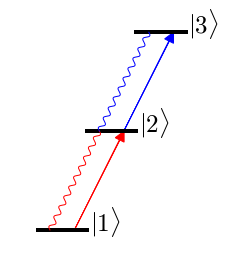

In [3]:
fig=pyplot.figure(); ax=fig.add_subplot(111,aspect="equal")

p1=[0.5,1]; p2=[1.5,3]; p3=[2.5,5]
draw_state(ax,p1,text=r"$|1\rangle$",l=1.0,alignment='right',label_displacement=0.05,fontsize=25,linewidth=4.0)
draw_state(ax,p2,text=r"$|2\rangle$",l=1.0,alignment='right',label_displacement=0.05,fontsize=25,linewidth=4.0)
draw_state(ax,p3,text=r"$|3\rangle$",l=1.0,alignment='right',label_displacement=0.05,fontsize=25,linewidth=4.0)

excitation(ax,[p1[0]+0.25,p1[1]],[p2[0]+0.25,p2[1]], fc="r", ec="r",width=0.01, head_width=0.2, head_length=0.2)
excitation(ax,[p2[0]+0.25,p2[1]],[p3[0]+0.25,p3[1]], fc="b", ec="b",width=0.01, head_width=0.2, head_length=0.2)

decay(     ax,[p1[0]-0.25,p1[1]],[p2[0]-0.25,p2[1]], 0.05,10.0,color="r",linewidth=1.0)
decay(     ax,[p2[0]-0.25,p2[1]],[p3[0]-0.25,p3[1]], 0.05,10.0,color="b",linewidth=1.0)

pyplot.axis('off')
pyplot.savefig(path+name+'_diagram.png',bbox_inches="tight")

We define the number of states and of radiation fields.

In [4]:
Ne=3
Nl=2

We define a few important symbols.

In [5]:
c,hbar,e,mu0, epsilon0=symbols("c hbar e mu0 varepsilon0",positive=True)
# fprint([c,hbar,e,mu0, epsilon0],print_ascii=print_ascii)

In [6]:
t,X,Y,Z,R,Phi=symbols("t X Y Z R Phi",real=True)
RR=Matrix([R*cos(Phi),R*sin(Phi),Z])
# RR=Matrix([X,Y,Z])
# fprint([t,RR],print_ascii=print_ascii)

We define the variables related to the laser field.

In [7]:
E0,omega_laser=define_laser_variables(Nl, variables=[t,R,Z])
# fprint(E0,print_ascii=print_ascii)

In [8]:
# fprint(omega_laser,print_ascii=print_ascii)

We write two electric fields propagating trough the $\hat{x}$ direction polarized in the $\hat{z}$ direction. First the wave vectors:

In [9]:
phi1=0 ; theta1=0; alpha1=pi/2; beta1=pi/8
phi2=0; theta2=pi; alpha2=pi/2; beta2=pi/8

k1=Matrix([cos(phi1)*sin(theta1),sin(phi1)*sin(theta1),cos(theta1)])
k2=Matrix([cos(phi2)*sin(theta2),sin(phi2)*sin(theta2),cos(theta2)])

k=[k1,k2]

# fprint(k,print_ascii=print_ascii)

The polarization vectors.

In [10]:
ep1=polarization_vector(phi1,theta1,alpha1,beta1, 1)
ep2=polarization_vector(phi2,theta2,alpha2,beta2, 1)

em1=ep1.conjugate()
em2=ep2.conjugate()

ep=[ep1,ep2]
em=[em1,em2]

# fprint([ep,em],print_ascii=print_ascii)

The electric field (evaluated in $\vec{R}=0$).

In [11]:
zero_vect=Matrix([0,0,0])
E_cartesian = [(+E0[l]            *ep[l]*exp(-I*omega_laser[l]*(t-k[l].dot(RR)/c)) 
                +E0[l].conjugate()*em[l]*exp(+I*omega_laser[l]*(t-k[l].dot(RR)/c)))/2 
                    for l in range(Nl)]

# fprint(E_cartesian,print_ascii=print_ascii)

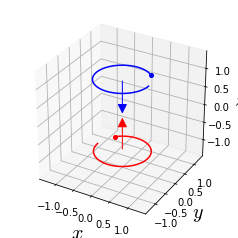

In [12]:
l1=PlaneWave(phi1,theta1,alpha1,beta1,color="red")
l2=PlaneWave(phi2,theta2,alpha2,beta2,color="blue")

laseres=[l1,l2]
Nl=len(laseres)

fig = pyplot.figure(); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,laseres,path+name+'_lasers.png')

We write the electric fields in the helicity basis (see notebook "Vectors in the helicity basis and the electric field").

In [13]:
E=[cartesian_to_helicity(E_cartesian[l]).expand() for l in range(Nl)]
# fprint(E,print_ascii=print_ascii)

We define the position operator.

In [14]:
r=define_r_components(Ne,helicity=True,explicitly_hermitian=True)
#Ladder means that r_{p;31}=0
r=[ri.subs({r[0][2,0]:0,r[1][2,0]:0,r[2][2,0]:0}) for ri in r]
# fprint(r,print_ascii=print_ascii)

The frequencies of the energy levels, the resonant frequencies, and the decay frequencies.

In [15]:
omega_level,omega,gamma=define_frequencies(Ne,explicitly_antisymmetric=True)
#Ladder means gamma31=0
gamma=gamma.subs({gamma[2,0]:0})

# fprint(omega_level,print_ascii=print_ascii)

In [16]:
# fprint(omega, print_ascii=print_ascii)

In [17]:
# fprint(gamma, print_ascii=print_ascii)

The atomic hamiltonian is

In [18]:
H0=Matrix([[hbar*omega_level[i]*KroneckerDelta(i,j) for j in range(Ne)] for i in range(Ne)])
# fprint(H0, print_ascii=print_ascii)

The interaction hamiltonian is

In [19]:
zero_matrix=zeros(Ne,Ne)
H1=sum([ e*helicity_dot_product(E[l],r) for l in range(Nl)],zero_matrix)
# fprint(H1,print_ascii=print_ascii)

and the complete hamiltonian is

In [20]:
H=H0+H1

# Rotating wave approximation
Notice that the electric field can be separated by terms with positive and negative frequency:

In [21]:
E_cartesian_p=[E0[l]/2            *ep[l]*exp(-I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]
E_cartesian_m=[E0[l].conjugate()/2*em[l]*exp(I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]

E_p=[cartesian_to_helicity(E_cartesian_p[l]) for l in range(Nl)]
E_m=[cartesian_to_helicity(E_cartesian_m[l]) for l in range(Nl)]

# fprint([E_p,E_m], print_ascii=print_ascii)

In [22]:
# fprint( simplify(sum([E[l] for l in range(Nl)],zero_vect)-(sum([E_p[l]+E_m[l] for l in range(Nl)],zero_vect) )), print_ascii=print_ascii)

The position operator can also be separated in this way. We go to the interaction picture (with $\hat{H}_0$ as the undisturbed hamiltonian)

In [23]:
r_I=[ Matrix([[exp(I*omega[i,j]*t)*r[p][i,j] for j in range(Ne)] for i in range(Ne)]) for p in range(3)]
# fprint(r_I[0], print_ascii=print_ascii)

In [24]:
# fprint(r_I[1], print_ascii=print_ascii)

In [25]:
# fprint(r_I[2], print_ascii=print_ascii)

Which can be decomposed in positive and negative frequencies as

In [26]:
r_I_p=[ Matrix([[ delta_greater(j,i)*exp(-I*omega[j,i]*t)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_I_p[0], print_ascii=print_ascii)

In [27]:
# fprint(r_I_p[1], print_ascii=print_ascii)

In [28]:
# fprint(r_I_p[2], print_ascii=print_ascii)

In [29]:
r_I_m=[ Matrix([[ delta_lesser( j,i)*exp( I*omega[i,j]*t)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_I_m[0],print_ascii=print_ascii)

In [30]:
# fprint(r_I_m[1], print_ascii=print_ascii)

In [31]:
# fprint(r_I_m[2], print_ascii=print_ascii)

that summed equal $\vec{\hat{r}}_I$

In [32]:
# fprint( [r_I[p]-(r_I_p[p]+r_I_m[p]) for p in range(3)] , print_ascii=print_ascii)

Thus the interaction hamiltonian in the interaciton picture is
\begin{equation}
    \hat{H}_{1I}=e\vec{E}\cdot \vec{\hat{r}}_I= e(\vec{E}^{(+)}\cdot \vec{\hat{r}}^{(+)}_I + \vec{E}^{(+)}\cdot \vec{\hat{r}}^{(-)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(+)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(-)}_I)
\end{equation}

In [33]:
H1I=sum([ e*helicity_dot_product(E[l],r_I) for l in range(Nl)],zero_matrix)
# fprint(H1I,print_ascii=print_ascii)

Since both $\omega^l$ and $\omega_{ij}$ are in the order of THz, the terms that have frequencies with the same sign are summed, and thus also of the order of THz. The frequencies in the terms with oposite signs however, are detunings of the order of MHz. Since we are only interested in the coarse-grained evolution of the density matrix, we may omit the fast terms and approximate

\begin{equation}
    \hat{H}_{1I} \simeq \hat{H}_{1I,RWA}= e( \vec{E}^{(+)}\cdot \vec{\hat{r}}^{(-)}_I + \vec{E}^{(-)}\cdot \vec{\hat{r}}^{(+)}_I )
\end{equation}

That is known as the rotating wave approximation (RWA).

In [34]:
H1IRWA=sum( [ (e*(helicity_dot_product(E_p[l],r_I_m)+helicity_dot_product(E_m[l],r_I_p))) for l in range(Nl)],zero_matrix)
# fprint(H1IRWA,print_ascii=print_ascii)

The matrix element $(\hat{H}_{1I,RWA})_{21}$ element is

In [35]:
# fprint(H1IRWA[1,0].expand(),print_ascii=print_ascii)

But if the detuning $\omega_{21}-\omega^1 \ll \omega_{21}-\omega^2$ (the second field is far detuned from the $1 \rightarrow 2$ transition), then $\omega_{21}-\omega^2$ may be also considered too high a frequency to be relevant to coarse-grained evolution. So we might neclect that term in $(\hat{H}_{1I,RWA})_{21}$ and similarly neglect the $\omega_{32}-\omega^1$ for term in $(\hat{H}_{1I,RWA})_{32}$:

In [36]:
# fprint(H1IRWA[2,1].expand(),print_ascii=print_ascii)

In other words, if the detunings in our experiments allow the approximmation, we might choose which frequency components $\omega^l$ excite which transitions. Let us say that $L_{ij}$ is the set of $l$ such that $\omega^l$ excites the transition $i\rightarrow j$

In [37]:
Lij=[[1,2,[1]],[2,3,[2]]]
Lij=formatLij(Lij,Ne)
print array(Lij)

[[[] [1] []]
 [[1] [] [2]]
 [[] [2] []]]


Thus the interacion hamiltonian in the interaction picture can be approximated as

In [38]:
H1IRWA =sum([ e*( helicity_dot_product( E_p[l],vector_element(r_I_m,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)
H1IRWA+=sum([ e*( helicity_dot_product( E_m[l],vector_element(r_I_p,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)

# fprint(H1IRWA, print_ascii=print_ascii)

Returning to the Schrödinger picture we have.

In [39]:
r_p=[ Matrix([[ delta_greater(j,i)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_p, print_ascii=print_ascii)

In [40]:
r_m=[ Matrix([[ delta_lesser( j,i)*r[p][i,j] for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
# fprint(r_m, print_ascii=print_ascii)

In [41]:
# fprint( [r[p]-(r_p[p]+r_m[p]) for p in range(3)] , print_ascii=print_ascii)

Thus the interaction hamiltonian in the Schrödinger picture in the rotating wave approximation is

In [42]:
H1RWA =sum([ e*( helicity_dot_product( E_p[l],vector_element(r_m,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)
H1RWA+=sum([ e*( helicity_dot_product( E_m[l],vector_element(r_p,i,j)) ) * ket(i+1,Ne)*bra(j+1,Ne) 
            for l in range(Nl) for j in range(Ne) for i in range(Ne) if l+1 in Lij[i][j] ],zero_matrix)

# fprint(H1RWA, print_ascii=print_ascii)

And the complete hamiltonian in the Schrödinger picture in the rotating wave approximation is

In [43]:
HRWA=H0+H1RWA
# fprint(HRWA, print_ascii=print_ascii)

# Rotating Frame
Next we will make a phase transformation in order to eliminate the explicit time dependance of the equations.

In [44]:
cc,cctilde,phase=define_psi_coefficients(Ne)
# fprint([cc,cctilde,phase], print_ascii=print_ascii)

In [45]:
phase=Matrix([ Function("theta_"+str(i+1),real=True)(t,Z) for i in range(Ne)])
# phase

In [46]:
psi=Matrix([ exp(I*phase[i])*cctilde[i] for i in range(Ne)])
# fprint(psi, print_ascii=print_ascii)

The Schrödinger equation $i\hbar \partial_t |\psi\rangle=\hat{H}_{RWA}$ is

In [47]:
lhs=Matrix([(I*hbar*Derivative(psi[i],t).doit()).expand() for i in range(Ne)])
# fprint(lhs, print_ascii=print_ascii)

In [48]:
rhs=HRWA*psi

We multiply each of these equations by $e^{-i \theta_i}$ and substracting $i \theta_i \tilde{c}_i$

In [49]:
lhs_new=Matrix([simplify(  lhs[i]*exp(-I*phase[i]) +hbar*Derivative(phase[i],t)*cctilde[i] ) for i in range(Ne)])
# fprint(lhs_new, print_ascii=print_ascii)

In [50]:
rhs_new=Matrix([simplify(  rhs[i]*exp(-I*phase[i])
                         +hbar*Derivative(phase[i],t)*cctilde[i] ).expand() for i in range(Ne)])
# fprint(rhs_new, print_ascii=print_ascii)

It can be seen that the equations loose their explicit time dependance only if $\omega^{1}(-Z/c+t) - \theta_{1} + \theta_{2}=0$ and $\omega^{2}(Z/c+t) - \theta_{2} + \theta_{3}=0$. Which is satisfied if

In [51]:
eq1=omega_laser[0]*(-Z/c+t)+phase[1]-phase[0]
eq2=omega_laser[1]*( Z/c+t)+phase[2]-phase[1]
pt=solve([eq1,eq2],[phase[1],phase[2]])
# pt

Thus the equations become

In [52]:
# fprint(lhs_new, print_ascii=print_ascii)

In [53]:
rhs_new=simplify(rhs_new.subs(pt)).expand().simplify()
# fprint(rhs_new, print_ascii=print_ascii)

It can be seen that this is the Schrödinger equation derived from an effective hamiltonian $\tilde{H}$

In [54]:
Htilde=Matrix([ [Derivative(rhs_new[i],cctilde[j]).doit().simplify() for j in range(Ne)] for i in range(Ne)])
# fprint(Htilde, print_ascii=print_ascii)

We can see that it is convenient to choose $\theta_1=-\omega_1$ to simplify the hamiltonian. Also, we can recognize $\omega^1-\omega_2+\omega_1=\delta^1$ as the detuning of the first field relative to the atomic transition $\omega_{21}=\omega_2-\omega_1$, and the same for $\omega^2-\omega_3+\omega_2=\delta^2$. And choosing $\theta_1=\omega_1 t$

In [55]:
delta1,delta2=symbols("delta1 delta2",real=True)
Htilde=Htilde.subs({phase[0]:-omega_level[0]*t}).doit()
Htilde=Htilde.subs({omega_laser[0]:delta1+omega_level[1]-omega_level[0]})
Htilde=Htilde.subs({omega_laser[1]:delta2+omega_level[2]-omega_level[1]})

Htilde=Htilde.expand()

# fprint(Htilde, print_ascii=print_ascii)

If we define the Rabi frequencies $\Omega_1 =e E_0^1 r_{0;21}/\hbar$ and $\Omega_2 =e E_0^2 r_{0;32}/\hbar$

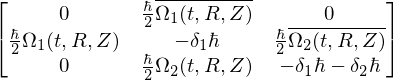

In [56]:
Omega1,Omega2=symbols("Omega1 Omega2",real=True)
Omega1,Omega2=symbols("Omega1 Omega2")
Omega1=Function("Omega1")(t,R,Z)
Omega2=Function("Omega2")(t,R,Z)

Htilde=Htilde.subs({E0[0]:Omega1*hbar/r[2][1,0]/e})
Htilde=Htilde.subs({E0[1]:Omega2*hbar/r[0][2,1]/e})

fprint(Htilde, print_ascii=print_ascii)

# Optical Bloch Equations

We define the density matrix.

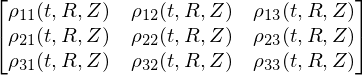

In [57]:
rho = define_density_matrix(Ne, variables=[t,R,Z])
fprint(rho , print_ascii=print_ascii)

The hamiltonian part of the equations is
\begin{equation}
    \dot{\hat{\rho}}=\frac{i}{\hbar}[\hat{\rho}, \hat{\tilde{H}}]
\end{equation}

In [58]:
hamiltonian_terms=(I/hbar*(rho*Htilde-Htilde*rho)).expand()
# fprint(hamiltonian_terms, print_ascii=print_ascii)

There are two Lindblad operators, since there are two spontaneous decay channels.

In [59]:
lindblad_terms =gamma[1,0]*lindblad_operator(ket(1,Ne)*bra(2,Ne),rho)
lindblad_terms+=gamma[2,1]*lindblad_operator(ket(2,Ne)*bra(3,Ne),rho)

# fprint(lindblad_terms, print_ascii=print_ascii)

The Optical Bloch equations are thus.

In [60]:
eqs = hamiltonian_terms + lindblad_terms

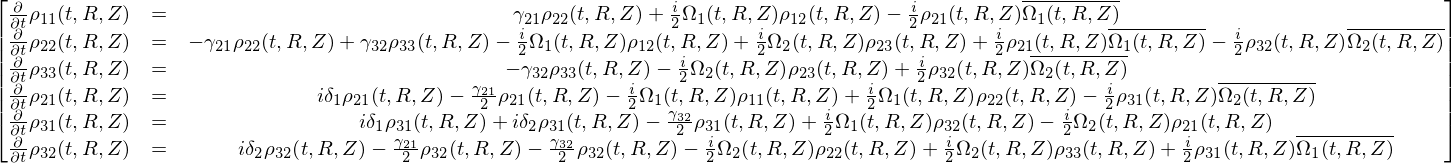

In [103]:
eqsign=symbols("=")
eqs_list=[]
for mu in range(0,Ne**2-1 -(Ne**2 - Ne)/2+1):
    ii,jj,s=IJ(mu,Ne)
    i=ii-1; j=jj-1
    eqs_list+=[[Derivative(rho[i,j],t),eqsign,eqs[i,j]]]
eqs_list=Matrix(eqs_list)
fprint(eqs_list, print_ascii=print_ascii)

# Wave equation

From Maxwell's equations in a dielectric medium it can be shown that in the abscence of bound charges, and magnetization currents, the electric field and the polazation of the medium follow the inhomogeneous wave equation.

\begin{equation}
    \nabla^2 \vec{E} - \frac{1}{c^2} \partial^2_t \vec{E}= \mu_0 \partial_t^2 \vec{P}
\end{equation}

We have also taken our fields to be of the form

\begin{equation}
    \vec{E}(t,\vec{R})=\vec{E}^{+}+\vec{E}^{-}=\frac{1}{2} \sum_l \vec{E}^{l(+)}(t,\vec{R}) e^{i(\vec{k}^l \cdot \vec{R} -\omega^l t)} +c.c.
\end{equation}

The $(+)$ part of the field is explicitly

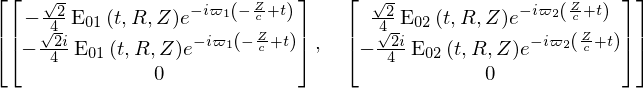

In [104]:
E_cartesian_p

introducing this into the wave equation we get

In [105]:
def laplacian_cylindric(scalar,coords,full=False):
    R,Phi,Z=coords
    return Derivative(scalar,Z,2).doit()

def laplacian_vec_cylindric(vector,coords,full=False):
    return Matrix([ laplacian_cylindric(vi,coords,full=full) for vi in vector])

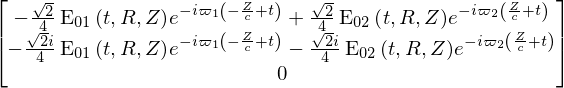

In [106]:
E_cartesian_p_tot = sum([E_cartesian_p[l] for l in range(Nl)], zero_vect)
E_cartesian_p_tot

In [107]:
term1=laplacian_vec_cylindric(E_cartesian_p_tot,[R,Phi,Z]) 
term2=-1/c**2*Matrix([Derivative(vi,t,2).doit() for vi in E_cartesian_p_tot])
lhs=term1+term2
#pprint(lhs,num_columns=150)

And if we consider the amplitudes as slowly varying envelopes (both in time and space) we can approximate them as

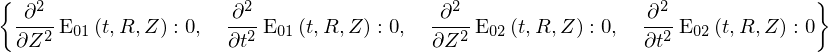

In [108]:
svea_subs={Derivative(E0[0],Z,2):0,Derivative(E0[1],Z,2):0,
           Derivative(E0[0],t,2):0,Derivative(E0[1],t,2):0}
svea_subs

In [109]:
lhs=lhs.subs(svea_subs)
lhs.simplify()
# lhs

On the other hand, we may approximate the macroscopic polarization of the atoms as varying only at the frequencies of the electric field components and at the same polarizations:

\begin{equation}
    \vec{P}=\frac{1}{2}\sum_l \vec{P}^{l(+)} e^{i(\vec{k}^l \cdot \vec{R} -\omega^l t)} +c.c.
\end{equation}


In [110]:
P0 = [Function("P_0^1")(t,R,Z), Function("P_0^2")(t,R,Z)]
# P0

In [111]:
P_cartesian_p=[P0[l]/2            *ep[l]*exp(-I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]
P_cartesian_m=[P0[l].conjugate()/2*em[l]*exp(I*omega_laser[l]*(t-k[l].dot(RR)/c)) for l in range(Nl)]

P_cartesian_p_tot=sum(P_cartesian_p, zero_vect)

# P_cartesian_p

The right-hand side of the wave equation

In [112]:
rhs=mu0*Matrix([Derivative(vi,t,2).doit() for vi in P_cartesian_p_tot])
#pprint(rhs)

And in another slowly varying approximation, the terms with $(\omega^1)^2$ are much larger than those with derivatives of the amplitudes.

In [113]:
svea_subs2={Derivative(P0[0],t,1):0, Derivative(P0[1],t,1):0,
            Derivative(P0[0],t,2):0, Derivative(P0[1],t,2):0}
# svea_subs2

In [114]:
rhs=rhs.subs(svea_subs2)
# pprint(rhs)

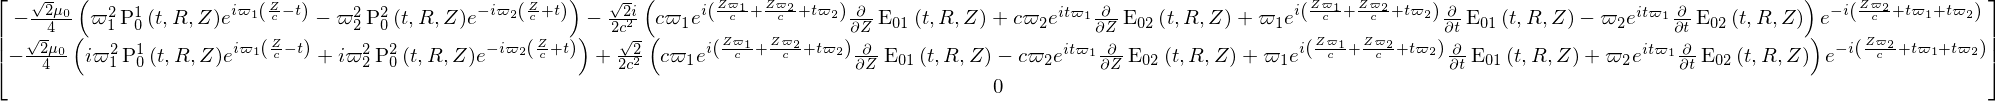

In [115]:
eqs_wave=lhs-rhs
# pprint(eqs_wave)
eqs_wave

These are three scalar equations each of which has coupled terms varying at high frequencies $\omega^l$. However, these frequencies can be decoupled if the polarization of the beams are orthogonal (as they are in our case). Taking a dot product with the polarizations we obtain one equation for each frequency component.

In [120]:
fact1=2*c**2*exp(I*omega_laser[0]*(t-Z/c))/(2*I*omega_laser[0])
lhs1=(fact1*ep[0].conjugate().dot(lhs)).expand()
rhs1=(fact1*ep[0].conjugate().dot(rhs)).expand()

# lhs1, rhs1

In [121]:
fact2=2*c**2*exp(I*omega_laser[1]*(t+Z/c))/(2*I*omega_laser[1])
lhs2=(fact2*ep[1].conjugate().dot(lhs)).expand()
rhs2=(fact2*ep[1].conjugate().dot(rhs)).expand()

# lhs2, rhs2

We take the spacial derivatives to the right-hand side. Just because we can.

In [122]:
lhs1=lhs1-c*Derivative(E0[0],Z)
rhs1=rhs1-c*Derivative(E0[0],Z)

lhs2=lhs2+c*Derivative(E0[1],Z)
rhs2=rhs2+c*Derivative(E0[1],Z)

We put these equations in terms of Rabi frequencies.

In [123]:
fact12=e*r[2][1,0]/hbar
lhs1=(fact12*lhs1.subs({E0[0]:Omega1*hbar/r[2][1,0]/e}).doit()).expand()
rhs1=(fact12*rhs1.subs({E0[0]:Omega1*hbar/r[2][1,0]/e}).doit()).expand()

Matrix([lhs1, eqsign, rhs1]).transpose()

In [124]:
fact22 = e*r[0][2,1]/hbar
lhs2 = (fact22*lhs2.subs({E0[1]: Omega2*hbar/r[0][2,1]/e}).doit()).expand()
rhs2 = (fact22*rhs2.subs({E0[1]: Omega2*hbar/r[0][2,1]/e}).doit()).expand()

Matrix([lhs2,eqsign,rhs2]).transpose()

We may relate the macroscopic polarization to the density matrix if we identify the quantum mechanics operator that corresponds to the polarization. Since the polarization is nothing but the density of dipole moment, we can see that

\begin{equation}
    \vec{P}=-n \mathrm{Tr}(e \vec{\hat{r}} \hat{\rho})
\end{equation}

notice that the minus sign comes from the fact that $\vec{\hat{r}}$ points in the direction of the electron relative to the proton, while the electric dipole moment points in the opposite direction. If we further make the asumption that each frequency component $l$ of the polarization is only driven by the transition $|i\rangle \leftrightarrow |j\rangle$ if $l\in L_{ij}$, then we may decompose $\vec{\hat{r}}$ into $l$ components as.

\begin{equation}
    \vec{\hat{r}} = \sum_l \vec{\hat{r}}^{l(+)} + \vec{\hat{r}}^{l(+)}
\end{equation}

Explicitly:

In [79]:
r_p_component=[ [ Matrix([ [ r_p[p][i,j] if l+1 in Lij[i][j] else 0
                            for j in range(Ne)  ] for i in range(Ne)])
                 for p in range(3)] for l in range(Nl)]

r_m_component=[ [ Matrix([ [ r_m[p][i,j] if l+1 in Lij[i][j] else 0
                            for j in range(Ne)  ] for i in range(Ne)])
                 for p in range(3)] for l in range(Nl)]

In [80]:
rpl1=r_p_component[0]
rpl2=r_p_component[1]

In [81]:
n=Function("n")(R,Z)
n

In [82]:
vh=Matrix(symbols("r_-,r0,r_+",real=True))
# vh,helicity_to_cartesian(vh)

In [83]:
rpl1_cartesian=[(rpl1[0]-rpl1[2])/sqrt(2),(rpl1[0]+rpl1[2])*I/sqrt(2),rpl1[1]]
# rpl1_cartesian

In [84]:
rpl2_cartesian=[(rpl2[0]-rpl2[2])/sqrt(2),(rpl2[0]+rpl2[2])*I/sqrt(2),rpl2[1]]
# rpl2_cartesian

The following factor of 2 comes from the fact that $P^{l(+)}/2 = -e n Tr(\vec{\hat{r}}^{l(+)}\hat{\rho})$

In [85]:
Ppl1=-2*n*e*Matrix([ (rpl1_cartesian[i]*rho).trace() for i in range(3)])
Ppl2=-2*n*e*Matrix([ (rpl2_cartesian[i]*rho).trace() for i in range(3)])

# Ppl1, Ppl2

Taking the dot product with the polarizations we get the polarization amplitudes in terms of density matrix elements.

In [86]:
Ppl1=ep[0].conjugate().dot(Ppl1).expand()
Ppl2=ep[1].conjugate().dot(Ppl2).expand()

# Ppl1, Ppl2

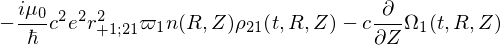

In [145]:
rhs1

In [87]:
rhs1=rhs1.subs({P0[0]:Ppl1})
rhs2=rhs2.subs({P0[1]:Ppl2})

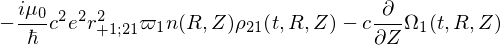

In [143]:
rhs1

In [144]:
P0[0]

# Maxwell-Bloch equations

And we add these equations to the Bloch equations

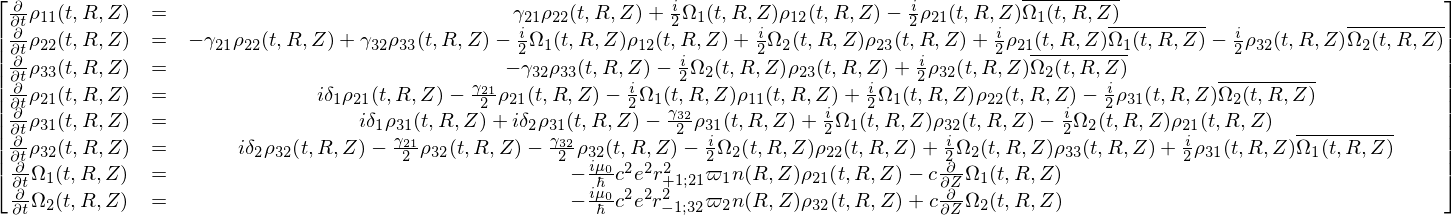

In [142]:
eqsign=symbols("=")
eqs_list=[]
for mu in range(0,Ne**2-1 -(Ne**2 - Ne)/2+1):
    ii,jj,s=IJ(mu,Ne)
    i=ii-1; j=jj-1
    eqs_list+=[[Derivative(rho[i,j],t),eqsign,eqs[i,j]]]

eqs_list += [[lhs1, eqsign, rhs1]]
eqs_list += [[lhs2, eqsign, rhs2]]

eqs_list=Matrix(eqs_list)
fprint(eqs_list, print_ascii=print_ascii)

Question: how to use calculations from detunings as a replacement for calculations for velocity classes.

# Linear approximation

We can linearize this equations by approximating all the population to be in $\rho_{11}$, and taking field $\Omega_1$ to be weak, and the coherences to be small. We will add an $\epsilon$ to all terms involving either coherences or signal field.

In [89]:
epsilon=symbols("varepsilon", real=True)
lin_subs={rho[0,0]:1, rho[1,1]:epsilon**2*rho[1,1], rho[2,2]:epsilon**2*rho[2,2],
          rho[1,0]:epsilon*rho[1,0], rho[0,1]:epsilon*rho[0,1],
          rho[2,0]:epsilon*rho[2,0], rho[0,2]:epsilon*rho[0,2],
          rho[2,1]:epsilon*rho[2,1], rho[1,2]:epsilon*rho[1,2],
          Omega1: epsilon*Omega1}
# lin_subs

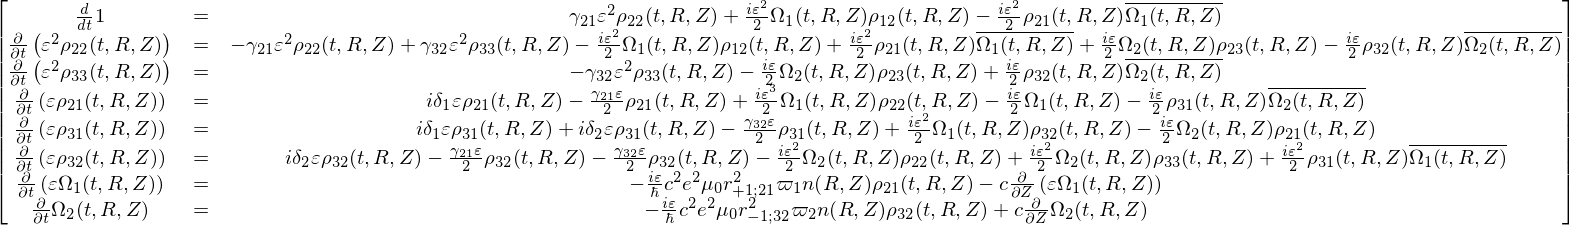

In [90]:
eqs_lin=eqs_list
eqs_lin=eqs_lin.subs(lin_subs)
fprint(eqs_lin, print_ascii=print_ascii)

And so, terms which are doubly small can be neglected.

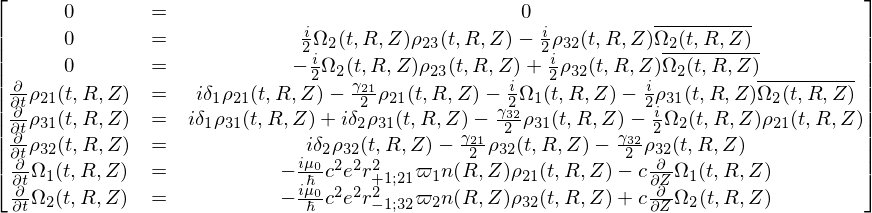

In [91]:
eqs_lin=eqs_lin.subs({epsilon**2:0}).subs({epsilon:1})
eqs_lin=eqs_lin.subs({Derivative(1,t):0,Derivative(0,t):0})
fprint(eqs_lin, print_ascii=print_ascii)

The equations for $\rho_{22}, \rho_{33}$ make a statement about the imaginary part of $\Omega_2\rho_{23}$ being zero. Let's just ignore that. The equation for $\rho_{32}$ is only coupled to itself, and can be easily solved

In [92]:
rho32_sol=exp((-(gamma[1,0]+gamma[2,1])/2+I*delta2)*t)
rho32_sol

In [93]:
Derivative(rho32_sol,t).doit().expand()-eqs_lin[5,2].subs({rho[2,1]:rho32_sol}).expand()

So the dynamics are captured by the equations for $\rho_{21}, \rho_{31}$ and the wave propagation equations.

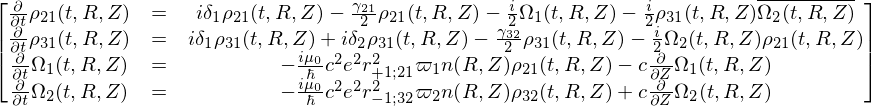

In [94]:
eqss=[[eqs_lin[3:5,:][0,0],eqsign,eqs_lin[3:5,:][0,2]],
      [eqs_lin[3:5,:][1,0],eqsign,eqs_lin[3:5,:][1,2]]]

eqss=eqss+[[eqs_lin[6: ,:][0,0],eqsign,eqs_lin[6: ,:][0,2]],
      [eqs_lin[6: ,:][1,0],eqsign,eqs_lin[6: ,:][1,2]]]

eqss=Matrix(eqss)
eqs_lin=eqss
eqs_lin

If we further consider $\Omega_2$ to be very strong we can neglect the first term on the right-hand side on the last equation.

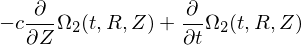

In [95]:
eqOmega2=eqs_lin[3,:][0]-eqs_lin[3,:][2]
eqOmega2=eqOmega2.subs({n:0})
eqOmega2

And thus solve that equation and take $\Omega_2$ as a given quantity. For instance, it might be a gaussian pulse with time duration $\tau_2$:

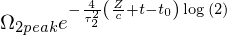

In [96]:
from sympy import log
Omega2_peak, tau2, t0=symbols("Omega2_peak, tau2, t0", positive=True)
Omega2_sol=Omega2_peak*exp(-4*log(2)*(t-t0+Z/c)/tau2**2)
Omega2_sol

In [97]:
eqOmega2.subs({Omega2:Omega2_sol}).doit()

 Then the equations are reduced to

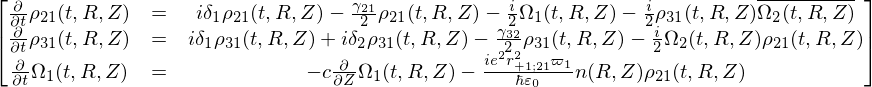

In [98]:
eqs_lin=eqs_lin[:-1,:].subs({c**2: 1/mu0/epsilon0})
eqs_lin

# The Doppler effect

The detunings of the fields however, will be different for different velocity classes in an atomic vapour.

In [99]:
vX, vY, vZ=symbols("v_X, v_Y, v_Z", real=True)
v = Matrix([vX, vY, vZ])
# v

For velocities $v \ll c$ the optical frequencies will be

\begin{equation}
    \varpi_l' = \varpi_l - \vec{k}_l \cdot \vec{v}_l 
\end{equation}

And so, in our case
\begin{equation}
    \delta_1' = \delta_1 - \varpi_1 v_Z/c, \hspace{1cm} \delta_2' = \delta_2 + \varpi_2 v_Z/c
\end{equation}

And the density matrix will be a mixture of contributions from all velocity classes
\begin{equation}
    \rho = \int dv_Z g(v_Z) \rho{v_Z}'
\end{equation}

So we will rewrite our equations in terms of this new $v_Z$

In [100]:
rhop=define_density_matrix(Ne, variables=[t,Z,vZ])
g=Function("g")(vZ)
g

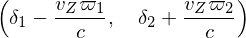

In [101]:
delta1p=delta1-omega_laser[0]*vZ/c
delta2p=delta2+omega_laser[1]*vZ/c
delta1p,delta2p

So our final equations are:

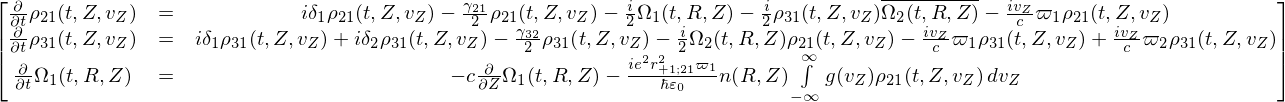

In [102]:
eqs_linv=eqs_lin.subs({delta1: delta1p, delta2: delta2p, rho[1,0]: rhop[1,0], rho[2,0]: rhop[2,0]})
eqs_linv[2,:]= eqs_lin[2,:].subs({rho[1,0]: Integral(g*rhop[1,0],(vZ,-oo,oo))})
eqs_linv=eqs_linv.expand()
eqs_linv

# Adiabatic approximation

In [103]:
rho21_ad = solve(eqs_linv[0, 2], rhop[1, 0])[0]
# rho21_ad

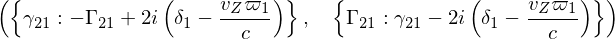

In [104]:
Gamma21 = symbols("Gamma_21")
Gamma32 = symbols("Gamma_32")
#Gamma/2 = gamma[1, 0]/2 - I*(delta1-vZ*omega_laser[0]/c)
ss_Gamma21 = {gamma[1, 0]: 2*(I*(delta1-vZ*omega_laser[0]/c)-Gamma21/2)}
ss_Gamma32 = {gamma[2, 1]: 2*(I*(delta2+vZ*omega_laser[1]/c)-Gamma32/2)}

ss_Gamma21_inv = {Gamma21: gamma[1, 0]- 2*I*(delta1-vZ*omega_laser[0]/c)}
ss_Gamma32_inv = {Gamma32: gamma[2, 1]- 2*I*(delta2+vZ*omega_laser[1]/c)}

ss_Gamma21, ss_Gamma21_inv

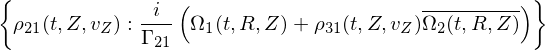

In [105]:
rho21_ad = simplify(rho21_ad.subs(ss_Gamma21))
ss_rho21_ad = {rhop[1, 0]: rho21_ad}
ss_rho21_ad

In [106]:
eq1 = eqs_linv[1, 2].subs(ss_rho21_ad)#.subs(ss_Gamma32).expand()
# eq1

We set this in two-photon resonance

In [107]:
eq1 = eq1.subs(delta1, -delta2).expand()
# eq1

In [108]:
eq2 = eqs_lin[2,2].subs(rho[1, 0], rhop[1, 0]).subs(ss_rho21_ad).expand()
# eq2

In [109]:
def group(expr, variables, return_coeffs=False):
    coefs = [Derivative(expr, variables[i]).doit() for i in range(len(variables))]
    expr_lin = sum([coefs[i]*variables[i] for i in range(len(variables))])
    remainder = (expr - expr_lin).expand()
    if return_coeffs:
        return coefs
    return expr_lin + remainder
variables = [rhop[2, 0], Omega1]
eq1 = group(eq1, variables)
eq2 = group(eq2, variables)

We define $\kappa$

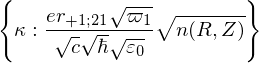

In [127]:
kappa = symbols("kappa", positive=True)
Deltak = symbols(r"\Delta_k", real=True)
tau = symbols("tau", real=True)
Omega2_p = Function("Omega2")(tau)
n_p = symbols("n", positive=True)

kz = symbols("k_z", real=True)
Omega1_hat = Function(r"\hat{\Omega}_1")(tau, kz)
rho31_hat = Function(r"\hat{\rho}_{31}")(tau, kz, vZ)

rr = -r_p[0][0, 1]

ss_kappa = {rr: kappa*sqrt(hbar*epsilon0*c/(n*omega_laser[0]*e**2))}
ss_kappa_inv = {kappa: rr*sqrt(n)/sqrt(hbar*epsilon0*c/(omega_laser[0]*e**2))}
ss_kappa_inv

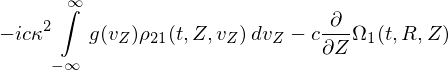

In [133]:
eqs_linv[2, 2].subs(ss_kappa)

In [135]:
eqs_linv[0, :]

So the equations in the adiabatic approximation are

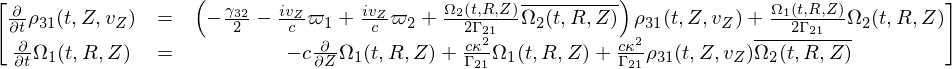

In [119]:
eqs_linva = Matrix([[Derivative(rhop[2, 0], t), eqsign, eq1],
                    [Derivative(Omega1, t), eqsign, eq2]]).subs(ss_kappa)
eqs_linva

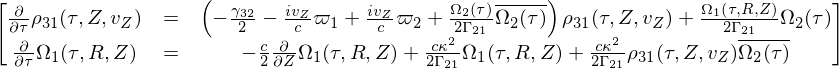

In [123]:


eqs_linva2 = eqs_linva.subs(t, tau)

eqs_linva2[1, 2] = eqs_linva2[1, 2]/2


eqs_linva2 = eqs_linva2.subs({Omega2.subs(t, tau): Omega2_p})
eqs_linva2 = eqs_linva2.subs(n, n_p)
eqs_linva2

In [122]:
S = Function("S")(tau, kz)
M = Matrix([group(eqs_linva_hat[i, 2], [rho31_hat, Omega1_hat], return_coeffs=True) for i in range(2)])/I
M = M.expand()
M

NameError: name 'eqs_linva_hat' is not defined

In [ ]:
xx = M[1, 0]/Omega2_p.conjugate()*Gamma21/-I*2
ss_rescale = {Omega1_hat: S*sqrt(xx)}
ss_rescale_inv = {S: Omega1_hat/sqrt(xx)}

In [ ]:
ss_Dop = {vZ*omega_laser[0]/c-vZ*omega_laser[1]/c: vZ*Deltak}
ss_Dop_inv = {vZ*Deltak: vZ*omega_laser[0]/c-vZ*omega_laser[1]/c}

ss_kappa_inv, ss_Gamma21_inv, ss_rescale_inv, ss_Dop_inv

So the equations in the adiabatic approximation are

In [113]:
eqs_linva = Matrix([[Derivative(rhop[2, 0], t), eqsign, eq1],
                    [Derivative(Omega1, t), eqsign, eq2]]).subs(ss_kappa)
eqs_linva

NameError: name 'ss_kappa' is not defined

We transform into the control field reference frame.

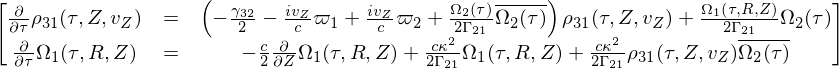

In [121]:


eqs_linva2 = eqs_linva.subs(t, tau)

eqs_linva2[1, 2] = eqs_linva2[1, 2]/2


eqs_linva2 = eqs_linva2.subs({Omega2.subs(t, tau): Omega2_p})
eqs_linva2 = eqs_linva2.subs(n, n_p)
eqs_linva2

We can then take a fourier transform of the Z dependence

In [ ]:

# Omega1_hat, rho31_hat

In [ ]:
eqs_linva_hat = eqs_linva2

eqs_linva_hat = eqs_linva_hat.subs(Derivative(Omega1, Z).subs(t, tau), I*kz*Omega1_hat)
eqs_linva_hat = eqs_linva_hat.subs(Omega1.subs(t, tau), Omega1_hat)
eqs_linva_hat = eqs_linva_hat.subs(rhop[2, 0].subs(t, tau), rho31_hat)
eqs_linva_hat

In [ ]:
M = Matrix([group(eqs_linva_hat[i, 2], [rho31_hat, Omega1_hat], return_coeffs=True) for i in range(2)])/I
M = M.expand()
M

In [ ]:

# xx, ss_rescale

In [ ]:
eq1 = eqs_linva_hat[0, 0]-eqs_linva_hat[0, 2]
eq1 = eq1.subs(ss_rescale)
eq1 = eq1 - Derivative(rho31_hat, tau)
# eq1

In [ ]:
eq2 = eqs_linva_hat[1, 0]-eqs_linva_hat[1, 2]
#eq2 = eq2.subs(ss_rescale).doit()
eq2 = (eq2.subs(ss_rescale).doit()/sqrt(xx)).expand()
eq2 = eq2 - Derivative(S, tau)
#eq2 = eq2.conjugate()
# eq2

In [ ]:
Y = Matrix([rho31_hat, S])
# Y

In [ ]:
eqss = [eq2, eq1]
M = Matrix([group(eqss[i], [S, rho31_hat], return_coeffs=True) for i in range(2)])/I
M = M.expand().subs(ss_kappa).subs(ss_Dop)
M

# Solution for square pulses.

Let's assume that the control field is constant for a duration $T$.

In [ ]:
T, Omega2a = symbols("T, Omega_2a", positive=True)
phi = symbols("phi", real=True)
T, Omega2a, phi

In [ ]:
ss_square = {Omega2_p: Omega2a*exp(I*phi)}
M_square = M.subs(ss_square)
M_square

In [ ]:
p, q, r, s = symbols("p, q, r, s")
ss_M = {M_square[0, 0]: p, M_square[0, 1]: q, M_square[1, 0]: r, M_square[1, 1]: s}
ss_M_inv = {ss_M[i]: i for i in ss_M}
ss_M_inv

In [ ]:
print ss_M_inv

In [ ]:
M_simp = M_square.subs(ss_M)
M_simp

We have equations

$$ \dot{X} = i M X $$

In [ ]:
sig = (s+p)/2
delt = (s-p)/2
alp = sig**2 - M_simp.det()
lamp, lamm = sig + sqrt(alp), sig - sqrt(alp)
lamp, lamm

In [ ]:
xp, xm = q, q
yp, ym = delt+sqrt(alp), delt-sqrt(alp)

In [ ]:
delt.subs(ss_M_inv)

In [ ]:
M_square

In [ ]:
A = Matrix([[xp, xm], [yp, ym]])
Ainv = Matrix([[ym, -xm], [-yp, xp]])/(xp*ym-xm*yp)
D = Matrix([[lamp, 0], [0, lamm]])

In [ ]:
A

In [ ]:
simplify(A*D*Ainv)

In [ ]:
x_p, x_m, y_p, y_m, lam_p, lam_m = symbols("x_+, x_-, y_+, y_-, \lambda_+, \lambda_-")
x_p, x_m, y_p, y_m, lam_p, lam_m

In [ ]:
ss_xy = {xp: x_p, yp: y_p, ym: y_m, lamp: lam_p, lamm: lam_m}
ss_xy_inv = {x_p: xp, x_m: xm, y_p: yp, y_m: ym, lam_p: lamp, lam_m: lamm}
# ss_xy

In [ ]:
A = Matrix([[x_p, x_m], [y_p, y_m]])
Ainv = Matrix([[y_m, -x_m], [-y_p, x_p]])/(x_p*y_m-x_m*y_p)
D = Matrix([[lam_p, 0], [0, lam_m]])
A, Ainv

In [ ]:
from sympy import eye
G = sum([A[:, i]*Ainv[i, :]*exp(I*T*D[i, i]) for i in range(2)], zeros(2, 2))
G = simplify(G)
G

In [ ]:
S_in = symbols("S_in")
rho31_in = symbols("rho_31in")
Yin = Y.subs({rho31_hat: 0, S: S_in})
Yint = Y.subs({rho31_hat: rho31_in, S: 0})
Yin, Yint

In [ ]:
G*Yin

In [ ]:
G*Yint

In [ ]:
Yint = G*Yin
Yint = Matrix([Yint[0, 0], 0])
Yout = G*Yint
Yout

In [ ]:
Sout = Yout[1, 0]#.expand()
Sout

In [ ]:
sigma, delta, alpha = symbols("sigma, delta, alpha")
ss_amazing1 = {sigma: (s+p)/2, delta: (s-p)/2, alpha: sig**2 - M_simp.det()}
print ss_amazing1
ss_amazing1

In [ ]:
ss_amazing2 = {lam_p: sigma+sqrt(alpha), lam_m: sigma-sqrt(alpha)}
ss_amazing2

In [ ]:
ss_amazing3 = {x_p: q, x_m: q}
ss_amazing3

In [ ]:
ss_amazing4 = {y_p: delta+sqrt(alpha), y_m: delta-sqrt(alpha)}
ss_amazing4

In [ ]:
Sout_ = Sout.subs(ss_amazing2).factor()
Sout_ = Sout_.subs({exp(I*T*sqrt(alpha))-exp(-I*T*sqrt(alpha)): 2*I*sin(T*sqrt(alpha))})
Sout_ = Sout_.subs(ss_amazing3).factor()
Sout_ = Sout_.subs(ss_amazing4)
Sout_ = Sout_.subs({(delta-sqrt(alpha))*(delta+sqrt(alpha)): delta**2-alpha})
Sout_

In [ ]:
Fk = Sout_/S_in
Fk

We check whether the phase in the exponential factor is real or imaginary.

In [ ]:
sigma_phase = 2*I*T*ss_amazing1[sigma].subs(ss_M_inv).subs(ss_Gamma21_inv)
sigma_phase

Unsurprisingly, decoherence goes to zero if the the decay frequencies are zero.

In [ ]:
re(sigma_phase).subs({gamma[1, 0]: 0, gamma[2, 1]: 0})

In [ ]:
ss_amazing1

In [ ]:
F_aux = Fk.subs(sigma, 0).subs(ss_amazing1).subs(ss_M_inv)#.factor()
F_aux

In [ ]:
from sympy import diff
def coeffs(expr, x, deg=1):
    coefs = []
    rem = expr
    for n in reversed(range(1, deg+1)):
        coef = diff(rem, x, n)/n
        term = coef*x**n
        rem = rem - term
        rem = rem.expand()
        coefs += [coef]
    coefs += [rem]
    return list(reversed(coefs))

In [ ]:
arg1 = F_aux.args[1].args[0].args[0]**2
fact1 = T**2*c/Gamma21**2*(kappa*Omega2a)**2*(sqrt(8)/4)**2
#fact1 = T**2/16/Gamma21**2

arg1_ = arg1/fact1
arg1_ = arg1_.factor().expand()
coefs1 = coeffs(arg1_, kz, 2)
arg1_=sum([coefs1[i]*kz**i for i in reversed(range(3))])
arg1_ = arg1_*fact1
arg1_

In [ ]:
arg2 = 1/(F_aux.args[0]*F_aux.args[2])
#fact2 = kappa**2*Omega2a**2/Gamma21**4/64/8* (8*c*kappa*Omega2a)**2
fact2 = 2
#fact2 = c*kappa**2*Omega2a**2/(64*Gamma21**4)

arg2_ = arg2/fact2
arg2_ = arg2_.factor().expand()

coefs2 = coeffs(arg2_, kz, 2)
arg2_=sum([coefs2[i]*kz**i for i in reversed(range(3))])
arg2_ = arg2_*fact2

arg2_

In [ ]:
(arg1-arg1_).expand(), (arg2-arg2_).expand()

In [ ]:
arg1 = arg1_
arg2 = arg2_
(arg1/fact1- arg2/fact2).expand()

In [ ]:
Ctilde, Z = symbols(r"\tilde{C}, Z")

ss_guillaume = {sqrt(arg1/fact1): Z, sqrt(fact1): Ctilde}
ss_guillaume_inv = {Z: sqrt(arg1/fact1), Ctilde: sqrt(fact1)}
ss_guillaume_inv

In [ ]:
den = arg2*(Z/ss_guillaume_inv[Z])**2
den = den.factor()
#den = den*(Ctilde/ss_guillaume_inv[Ctilde])**2
den

In [ ]:
F_guillaume = sin(Ctilde*Z)**2/den*exp(2*I*T*sigma)
F_guillaume

In [ ]:
#F_guillaume2=F_guillaume.subs(ss_guillaume_inv).expand()
#arg_gui1 = F_guillaume2.args[3].args[0].args[0]

arg_gui1 = (Z*Ctilde).subs(ss_guillaume_inv)
arg_gui1 = arg_gui1**2

F_aux2 = Fk.subs(sigma, 0).subs(ss_amazing1).subs(ss_M_inv).expand()
arg_aux1 = F_aux2.args[4].args[0].args[0]
arg_aux1 = arg_aux1**2

(arg_aux1-arg_gui1).expand()

In [ ]:
arg_gui2 = 2*Z**2
arg_gui2 = arg_gui2.subs(ss_guillaume_inv).expand()

Fk_aux2 = Fk.subs(sigma, 0)
arg_aux2 = Fk_aux2.args[0]*Fk_aux2.args[2]
arg_aux2 = arg_aux2.subs(ss_amazing1).subs(ss_M_inv)
arg_aux2 = (1/arg_aux2).expand()

arg_aux2-arg_gui2

In [ ]:
a, b, cc = symbols("a, b, c")
f = a*kz**2 + b*kz + cc
f

In [ ]:
ff = a*(kz-solve(f, kz)[0])*(kz-solve(f, kz)[1])
ff, ff.expand()-f

In [ ]:
fff = sqrt(ff)
fff

In [ ]:
(fff-sqrt(a)*kz).limit(kz, oo)

In [ ]:
diff(fff, kz).limit(kz, -oo)

In [ ]:
from sympy import series

In [ ]:
series(sqrt(f), kz, 0, 2)

In [ ]:
solve(diff(ss_guillaume_inv[Z]**2, kz), kz)[0].expand().subs(vZ, 0)

# Decoherence
Solving the second equation in the abscence of a control field we obtain a spin wave proportional to

In [ ]:
Delta, sigma = symbols("Delta sigma", positive=True)
f = exp(I*Delta*t*vZ)
f

In [ ]:
g=1/sqrt(2*pi)/sigma*exp(-(vZ/sigma)**2/2)
g

In [ ]:
Doppler_decoherence=integrate(g*f, (vZ, -oo, oo)).factor()
Doppler_decoherence

In [ ]:
decoherence = Doppler_decoherence*exp(-gamma[2, 1]*t/2)
decoherence

In [ ]:
solve(log(Doppler_decoherence**2)+1, t)

In [ ]:
solve(log(decoherence**2)+1, t)

In [ ]:
A, B, C = symbols("A, B, C")
omega87, omega97 = symbols("omega87, omega97", positive=True)

In [ ]:
decoherence_hfs = decoherence*(A+B*exp(I*omega87*t)+C*exp(I*omega97*t))/(A+B+C)
decoherence_hfs

In [ ]:
eta_hfs = decoherence_hfs*decoherence_hfs.conjugate()
eta_hfs

In [ ]:
D = symbols("D", positive=True)

In [ ]:
eq = eta_hfs
eq = eq.subs({(A+B+C)*(A+B+C).conjugate(): 1}) -exp(-1)*D
eq = eq.expand()
eq

[1]  H.J. Metcalf and P. van der Straten. Laser Cooling and Trapping. Graduate Texts in Contempo-
rary Physics. Springer New York, 2001.

[2] Daniel Adam Steck. Quantum and Atom Optics. Oregon Center for Optics and Department of Physics, University of Oregon Copyright © 200